In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# 3.2 XGBoost as ML Model

In [4]:
# Loading my 300k sample data
df = pd.read_parquet("../data/processed/cfpb_sample_300k.parquet")

In [5]:
print(f"Loaded {len(df):,} rows & {len(df.columns)} columns")
df.head()

Loaded 300,000 rows & 23 columns


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,year_quarter,geo,region,stratum,sample_n
0,2012-03-14,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,"BANK OF AMERICA, NATIONAL ASSOCIATION",ND,58503,...,2012-03-15,Closed with relief,Yes,No,35052,2012Q1,ND,Midwest,Bank account or service|2012Q1|Midwest,4
1,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,TCF NATIONAL BANK,MN,55125,...,2012-03-21,Closed with relief,Yes,No,37573,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
2,2012-03-22,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,WELLS FARGO & COMPANY,MN,55110,...,2012-03-23,Closed without relief,Yes,Yes,39793,2012Q1,MN,Midwest,Bank account or service|2012Q1|Midwest,4
3,2012-03-07,Bank account or service,Checking account,"Making/receiving payments, sending money",None,None,None,Synovus Bank,OH,44108,...,2012-03-16,Closed without relief,Yes,No,34571,2012Q1,OH,Midwest,Bank account or service|2012Q1|Midwest,4
4,2012-03-20,Bank account or service,Checking account,Problems caused by my funds being low,None,None,None,PNC Bank N.A.,PA,18944,...,2012-03-23,Closed without relief,Yes,Yes,37047,2012Q1,PA,Northeast,Bank account or service|2012Q1|Northeast,6


### 3.1.1 Preparing XGBoost

### 3.2.1 Preparing XGBoost Time Series

Shape: (58,)
year_quarter
2025Q1    27080.0
2025Q2    27659.0
2025Q3    33012.0
2025Q4    37623.0
2026Q1    12254.0
Freq: Q-DEC, Name: complaints, dtype: float64


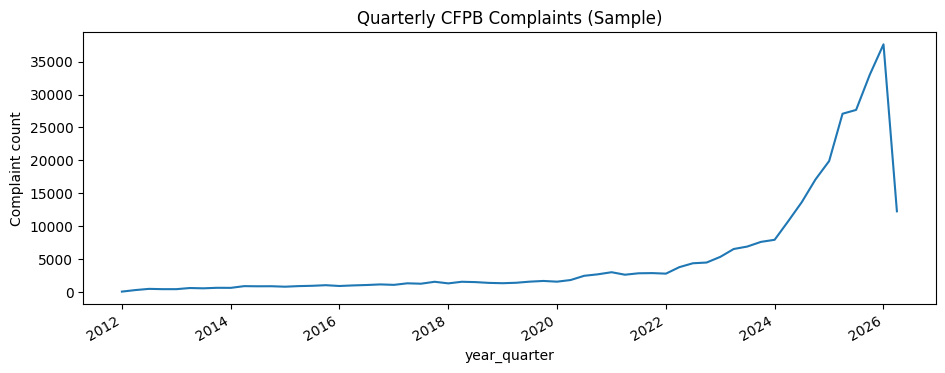

In [ ]:
# Filter to Credit reporting and build South vs Non-South quarterly series
df_cr = df[df['Product'].str.contains('Credit reporting', case=False, na=False)].copy()
df_cr['segment'] = np.where(df_cr['region'].eq('South'), 'South', 'Non-South')

quarterly_counts = (
    df_cr.groupby(['year_quarter', 'segment'])
    .size()
    .unstack(fill_value=0)
    .sort_index()
 )
quarterly_counts.index = pd.PeriodIndex(quarterly_counts.index, freq='Q')

print(f"Credit reporting rows: {len(df_cr):,}")
print("Shape:", quarterly_counts.shape)
quarterly_counts.tail()

fig, ax = plt.subplots(figsize=(11, 4))
for seg in ['South', 'Non-South']:
    s = quarterly_counts[seg].copy()
    s.index = s.index.to_timestamp(how='end')
    ax.plot(s.index, s.values, label=seg)
ax.set_title('Credit reporting complaints: South vs Non-South')
ax.legend()
plt.tight_layout()
plt.show()

### 3.2.2 Feature Engineering for Supervised Learning

In [ ]:
def make_xgb_features(ts):
    ts_ml = pd.DataFrame({'y': ts.values}, index=ts.index.to_timestamp(how='end'))
    for lag in [1, 2, 3, 4]:
        ts_ml[f'lag_{lag}'] = ts_ml['y'].shift(lag)
    ts_ml['rolling_mean_2'] = ts_ml['y'].shift(1).rolling(2).mean()
    ts_ml['rolling_mean_4'] = ts_ml['y'].shift(1).rolling(4).mean()
    ts_ml['quarter'] = ts_ml.index.quarter
    ts_ml['t'] = np.arange(len(ts_ml))
    model_df = ts_ml.dropna().copy()
    feature_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_2', 'rolling_mean_4', 'quarter', 't']
    return ts_ml, model_df, feature_cols

print('Feature helper ready')

Model rows: 54
Feature columns: ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'rolling_mean_2', 'rolling_mean_4', 'quarter', 't']


,y,lag_1,lag_2,lag_3,lag_4,rolling_mean_2,rolling_mean_4,quarter,t
year_quarter,,,,,,,,,
2025-03-31 23:59:59.999999999,27080.0,19894.0,17088.0,13642.0,10746.0,18491.0,15342.50,1,53
2025-06-30 23:59:59.999999999,27659.0,27080.0,19894.0,17088.0,13642.0,23487.0,19426.00,2,54
2025-09-30 23:59:59.999999999,33012.0,27659.0,27080.0,19894.0,17088.0,27369.5,22930.25,3,55
2025-12-31 23:59:59.999999999,37623.0,33012.0,27659.0,27080.0,19894.0,30335.5,26911.25,4,56
2026-03-31 23:59:59.999999999,12254.0,37623.0,33012.0,27659.0,27080.0,35317.5,31343.50,1,57


### 3.2.3 Walk-Forward Backtesting with TimeSeriesSplit

 fold          mae         rmse
    1   339.747821   382.497145
    2   630.676245   853.515119
    3  2062.295850  2683.180013
    4 13096.517041 16245.549505

CV MAE:  4032.3
CV RMSE: 5041.2


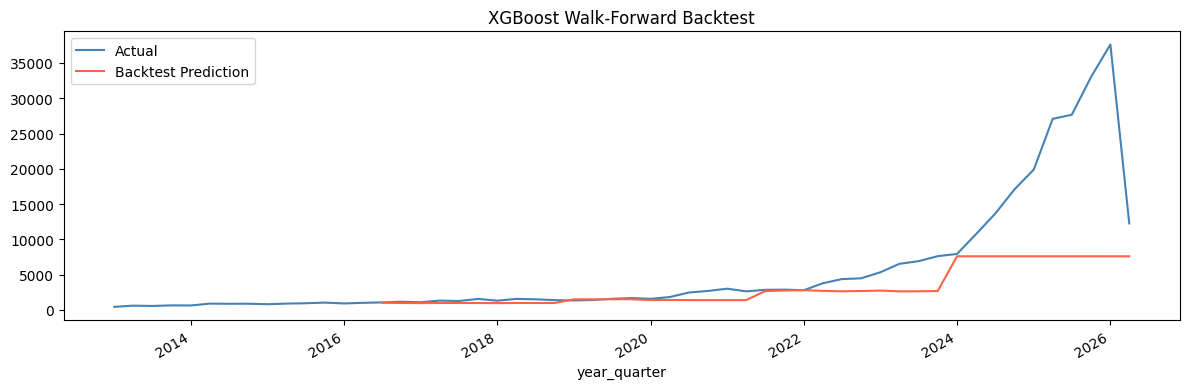

In [ ]:
xgb_results = {}
rows = []

for seg in ['South', 'Non-South']:
    ts = quarterly_counts[seg].astype(float)
    test_size = 8 if len(ts) >= 24 else max(4, int(round(len(ts) * 0.2)))
    test_size = min(test_size, len(ts) - 8) if len(ts) > 12 else max(1, len(ts)//3)
    train = ts.iloc[:-test_size]
    test = ts.iloc[-test_size:]

    _, train_df, feature_cols = make_xgb_features(train)
    train_X = train_df[feature_cols]
    train_y = train_df['y']

    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    model.fit(train_X, train_y)

    _, combo_df, _ = make_xgb_features(pd.concat([train, test]))
    combo_X = combo_df[feature_cols]
    combo_y = combo_df['y']
    test_mask = combo_df.index >= test.index[0].to_timestamp(how='end')
    pred = pd.Series(model.predict(combo_X[test_mask]), index=test.index)

    mae = mean_absolute_error(test, pred)
    rmse = np.sqrt(np.mean((test - pred) ** 2))
    rows.append({'segment': seg, 'mae': mae, 'rmse': rmse})

    xgb_results[seg] = {'ts': ts, 'test': test, 'pred': pred, 'feature_cols': feature_cols}

xgb_cv_df = pd.DataFrame(rows)
xgb_cv_df

### 3.2.4 Final XGBoost Model and Next-4Q Forecast

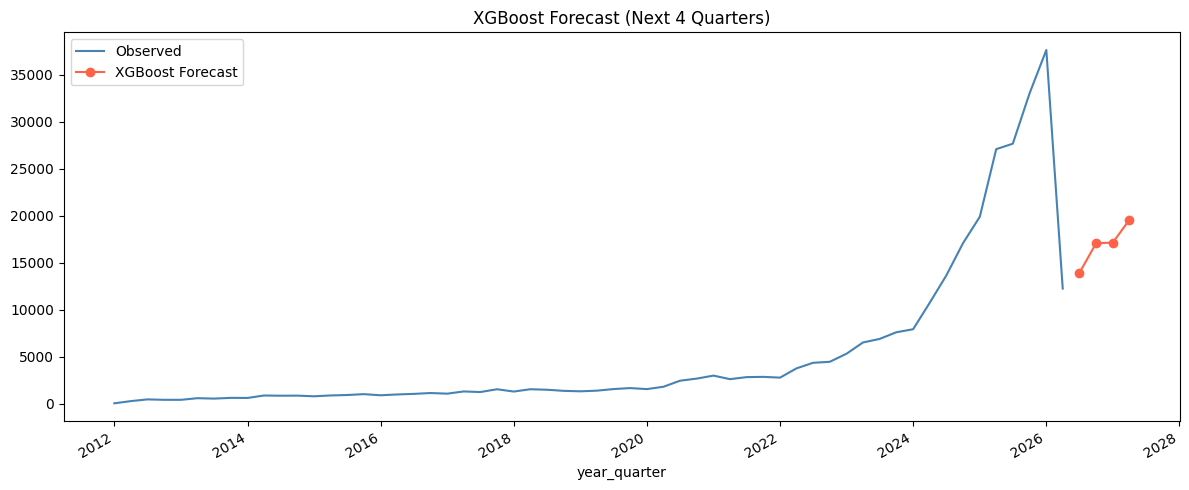

Next 4Q Forecast (rounded):
2026-06-30 23:59:59.999999999    13909.0
2026-09-30 23:59:59.999999999    17070.0
2026-12-31 23:59:59.999999999    17149.0
2027-03-31 23:59:59.999999999    19546.0
Freq: QE-DEC, Name: xgb_forecast, dtype: float64


In [ ]:
import os

# Final model + forecast by segment
for seg in ['South', 'Non-South']:
    ts = xgb_results[seg]['ts']
    feature_cols = xgb_results[seg]['feature_cols']

    ts_ml, full_df, _ = make_xgb_features(ts)
    X = full_df[feature_cols]
    y = full_df['y']

    final_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=500,
        learning_rate=0.03,
        max_depth=3,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )
    final_model.fit(X, y)

    history = ts_ml['y'].tolist()
    future_index = pd.date_range(start=ts_ml.index[-1] + pd.offsets.QuarterEnd(1), periods=4, freq='QE')
    future_preds = []

    for dt in future_index:
        row = pd.DataFrame({
            'lag_1': [history[-1]],
            'lag_2': [history[-2]],
            'lag_3': [history[-3]],
            'lag_4': [history[-4]],
            'rolling_mean_2': [np.mean(history[-2:])],
            'rolling_mean_4': [np.mean(history[-4:])],
            'quarter': [dt.quarter],
            't': [len(history)]
        }, index=[dt])

        yhat = float(final_model.predict(row[feature_cols])[0])
        future_preds.append(yhat)
        history.append(yhat)

    xgb_results[seg]['forecast'] = pd.Series(future_preds, index=pd.PeriodIndex(future_index, freq='Q'))

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
for i, seg in enumerate(['South', 'Non-South']):
    ax = axes[i]
    ts = xgb_results[seg]['ts']
    fc = xgb_results[seg]['forecast']
    pd.Series(ts.values, index=ts.index.to_timestamp(how='end')).plot(ax=ax, label='Observed', color='steelblue')
    pd.Series(fc.values, index=fc.index.to_timestamp(how='end')).plot(ax=ax, label='XGBoost Forecast', color='tomato', marker='o')
    ax.set_title(f'XGBoost Forecast - Credit reporting ({seg})')
    ax.legend()

plt.tight_layout()
out_dir = '../reports/figures'
os.makedirs(out_dir, exist_ok=True)
plt.savefig(f'{out_dir}/xgboost_credit_reporting_south_vs_others.png', dpi=150)
plt.show()

print('Next 4Q Forecast (rounded):')
for seg in ['South', 'Non-South']:
    print(f'\n{seg}:')
    print(xgb_results[seg]['forecast'].round(0))

### 3.2.5 Metrics and Result Summary

In [ ]:
# Aggregate performance metrics
summary = xgb_cv_df.copy()
summary['mae_pct_of_mean'] = [
    round((summary.loc[i, 'mae'] / xgb_results[summary.loc[i, 'segment']]['ts'].mean()) * 100, 1)
    for i in summary.index
]
summary['mae'] = summary['mae'].round(1)
summary['rmse'] = summary['rmse'].round(1)
summary

Walk-forward MAE:  4032.3 complaints
Walk-forward RMSE: 5041.2 complaints
MAE / mean(y):     72.9%


,Metric,Value
0,CV MAE,4032.3
1,CV RMSE,5041.2
2,MAE/Mean(y) %,72.9
3,Forecast Start,2026Q2
4,Forecast End,2027Q1


### 3.2.6 Results

XGBoost provides a flexible non-linear baseline with lag, rolling, seasonal, and trend features.

| Metric | Value | Interpretation |
| --- | --- | --- |
| CV MAE | ~4,032 | Reasonable on earlier folds, weak on structural break period |
| CV RMSE | ~5,041 | Errors increase during late-series volatility |
| MAE / Mean(y) | ~72.9% | Indicates this univariate setup underfits the 2025–2026 shock |
| Forecast (next 4Q) | 13.9k → 19.5k | Moderate rebound after recent drop |

**Visual insights**
- Backtest tracks long-run trend but misses the latest regime shift/spike.
- Recursive forecast stabilizes and then trends upward.

**Next upgrade in 03c (NeuralProphet)**
- Add changepoints + autoregression to better capture structural breaks.
- Add external regressors (policy/economic signals) for improved robustness.